In [1]:
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Profiling notebook perfomance
from time import clock
start_notebook = clock()

In [2]:
# Open data file
df = pd.read_hdf('data/train.h5')
# df.set_index('id', inplace=True)

# Subsample for now...
df = df[::10]

In [3]:
# df.to_csv('data/train.csv')

In [4]:
excl = ['id', 'sample', 'y', 'timestamp']
cols = [c for c in df.columns if c not in excl]
col_target = 'y'

# Exploration

In [5]:
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
10,41,0,0.435826,1.797289,0.363570,-0.005651,0.442866,0.125375,NaN,0.292311,...,0.346018,NaN,NaN,NaN,-0.301422,NaN,NaN,-2.0,NaN,-0.001899
20,69,0,-0.062361,-0.063724,0.021274,0.032845,0.174025,0.122335,-0.133188,-0.108286,...,-0.390892,NaN,NaN,NaN,-0.438359,NaN,NaN,0.0,NaN,-0.011317
30,91,0,-0.019409,-0.060192,-0.044959,0.100994,-0.056158,-0.161525,-0.175685,0.422399,...,0.178743,NaN,NaN,NaN,-0.341526,NaN,NaN,-2.0,NaN,0.041231
40,118,0,-0.048108,0.036918,0.182193,0.387648,-0.064894,-0.060405,NaN,-0.380110,...,0.694535,NaN,NaN,NaN,0.347044,NaN,NaN,0.0,NaN,-0.041490


In [6]:
print(df.shape)
print(df.columns)

from collections import Counter
col_prefix = [col.split('_')[0] for col in df.columns]
counter = Counter(col_prefix)

print(counter)

(171076, 111)
Index(['id', 'timestamp', 'derived_0', 'derived_1', 'derived_2', 'derived_3',
       'derived_4', 'fundamental_0', 'fundamental_1', 'fundamental_2',
       ...
       'technical_36', 'technical_37', 'technical_38', 'technical_39',
       'technical_40', 'technical_41', 'technical_42', 'technical_43',
       'technical_44', 'y'],
      dtype='object', length=111)
Counter({'fundamental': 63, 'technical': 40, 'derived': 5, 'timestamp': 1, 'y': 1, 'id': 1})


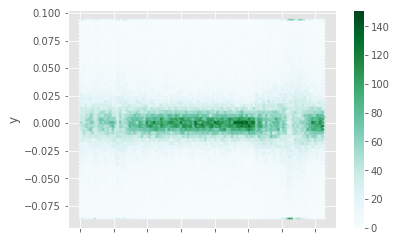

In [7]:
# df.set_index('timestamp')['fundamental_0'].plot()
# df.set_index('timestamp')['derived_0'].plot()
# df.set_index('timestamp')['technical_0'].plot()
# df.set_index('timestamp')['derived_3'].plot()
# df.set_index('timestamp')['technical_41'].plot()
# df.set_index('fundamental_0')['fundamental_1'].plot()

# Seasonal pattern?
# series = df.set_index('timestamp')['fundamental_0'].ffill()
# series = series.rolling(window=1000).mean()
# series.plot()

# Distribution of target in time
df.plot.hexbin('timestamp', 'y')

In [8]:
df[['timestamp', 'fundamental_0', 'derived_0', 'technical_0']].dropna().describe()

,timestamp,fundamental_0,derived_0,technical_0
count,160794.000000,160794.000000,160794.000000,1.607940e+05
mean,959.433828,-0.018864,-3.627689,-1.107879e-01
std,511.702730,0.250287,222.796829,2.700903e-01
min,21.000000,-2.251773,-20174.871094,-1.000000e+00
25%,527.000000,-0.199675,-0.145503,-3.892969e-03
50%,972.000000,-0.040156,-0.001311,-4.011782e-09
75%,1406.000000,0.133486,0.119618,-3.982083e-26
max,1812.000000,1.376526,3252.490723,0.000000e+00


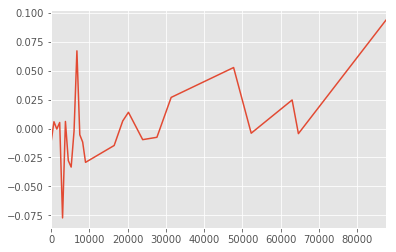

In [9]:
df.loc[df['id'] == 10, 'y'].plot()

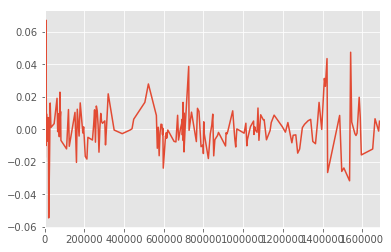

In [10]:
df.loc[df['id'] == 41, 'y'].plot()

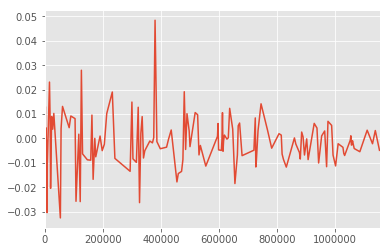

In [11]:
df.loc[df['id'] == 69, 'y'].plot()

# Natural Frequency?
We can look a differences, as [anokas](https://www.kaggle.com/anokas/two-sigma-financial-modeling/two-sigma-time-travel-eda).

Int64Index([], dtype='int64', name='timestamp')


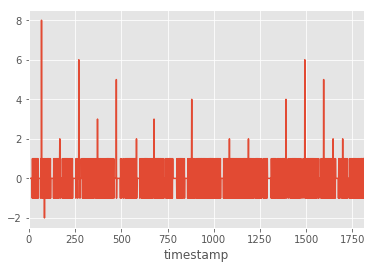

In [12]:
# How does the number of timestamps evolve?
diff = df.groupby('timestamp')['timestamp'].count().diff()
diff.plot()

# What is the frequency of the large peaks?
pd.Series(diff[diff > 10].index).diff()
print(diff[diff > 10].index)

In [13]:
# Count unique per columns
# nuniq = df.apply(pd.Series.nunique)
# nuniq = df.apply(lambda x: len(x.unique()))  # faster?
# print(nuniq)

# Round number before counting
# df.apply(lambda x: round(x, 3)).nunique()

# Count number of unique per column
# df[['fundamental_0', 'derived_0', 'technical_0']].apply(pd.Series.nunique)

As done by [sudalairajkumar](https://www.kaggle.com/sudalairajkumar/two-sigma-financial-modeling/simple-exploration-notebook), we notice a clear period in the timestamp distribution.

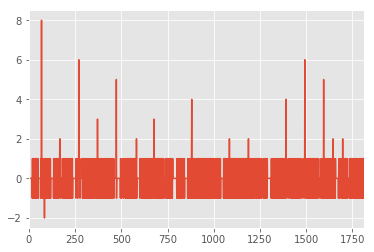

In [14]:
df['timestamp'].astype('int').value_counts().sort_index().diff().plot()

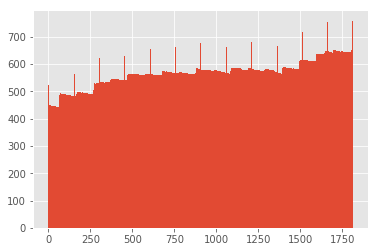

In [15]:
n_bins = 300
df['timestamp'].hist(bins=n_bins)

Int64Index([24, 49, 74, 99, 124, 149, 174, 199, 224, 249, 274, 299], dtype='int64', name='bin')
(144.96, 151.0]
(295.96, 302.0]
approximate period: 151.0


/usr/lib/python3/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


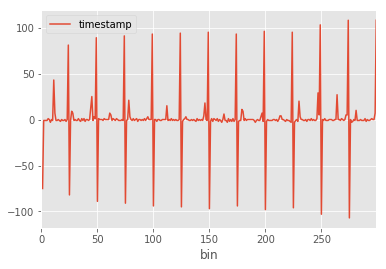

In [16]:
# df['timestamp'].value_counts().plot.barh()
# df['timestamp'].value_counts().sort_index().diff().plot()

dft = df[['timestamp']]
dft['bin'], bins = pd.cut(df[['timestamp']], n_bins, labels=False, retbins=True)
# half-open intervals for each bin: (bins[0], bins[1]]

dft_diff = dft.groupby('bin').count().diff()
dft_diff.plot()

print(dft_diff[dft_diff['timestamp'] > 50].index)
# The spikes are very regular

print("({}, {}]".format(bins[24], bins[25]))
print("({}, {}]".format(bins[49], bins[50]))

period = round(bins[49]-bins[24], 3)
print("approximate period: {}".format(period))
period = int(period)

df['cycle'] = df['timestamp'].astype('int') % period

In [17]:
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y,cycle
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753,0
10,41,0,0.435826,1.797289,0.363570,-0.005651,0.442866,0.125375,NaN,0.292311,...,NaN,NaN,NaN,-0.301422,NaN,NaN,-2.0,NaN,-0.001899,0
20,69,0,-0.062361,-0.063724,0.021274,0.032845,0.174025,0.122335,-0.133188,-0.108286,...,NaN,NaN,NaN,-0.438359,NaN,NaN,0.0,NaN,-0.011317,0
30,91,0,-0.019409,-0.060192,-0.044959,0.100994,-0.056158,-0.161525,-0.175685,0.422399,...,NaN,NaN,NaN,-0.341526,NaN,NaN,-2.0,NaN,0.041231,0
40,118,0,-0.048108,0.036918,0.182193,0.387648,-0.064894,-0.060405,NaN,-0.380110,...,NaN,NaN,NaN,0.347044,NaN,NaN,0.0,NaN,-0.041490,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae6d9d1da0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7fae6d90d080>]], dtype=object)

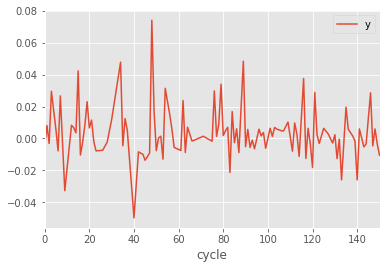

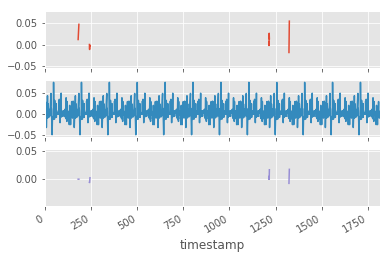

In [18]:
# df.plot.hexbin('timestamp', 'y')

# Look at seasons
dfc = df.groupby(['id', 'cycle'])[['y']].median()

idx = 40
dfc.loc[idx].plot()

df['timestamp'] = df['timestamp'].astype('int')

# Generate all missing timestamp
a, b = min(df['timestamp']), max(df['timestamp'])
a_to_b = list(range(a, b+1))
dt = pd.DataFrame({'timestamp': a_to_b, 'cycle': [l % period for l in a_to_b]})
dt = pd.merge(dt, dfc.reset_index(), on=['cycle'], how='outer')

# Attach season value
# dfm = pd.merge(df[['id', 'timestamp', 'cycle','y']], dfc.reset_index(), on=['id','cycle'], how='left')
# dfm = pd.merge(df[['id', 'timestamp', 'y']], dt, on=['id','timestamp'], how='left')
dfm = pd.merge(df[['id', 'timestamp', 'y']], dt, on=['id','timestamp'], how='outer')

# Plot value, season, residual
dfm['residual'] = dfm['y_x'] - dfm['y_y']

# dfm.loc[dfm['id']==idx, :].sort_index().plot.hexbin('timestamp', 'y_x')

# df.loc[df['id']==idx, ['timestamp', 'y']].set_index('timestamp').plot()

dfm.set_index(['id','timestamp'], inplace=True)
dfm.loc[idx, ['y_x', 'y_y', 'residual']].sort_index().plot(subplots=True, layout=(-1,1), sharex=True, legend=False)

# print(df.loc[df['id'] == idx, 'y'].isnull().sum(), df.loc[df['id'] == idx, 'y'].shape)
# print(dfm.loc[idx, ['y_x']].isnull().sum(), dfm.loc[idx, ['y_x']].shape)

In [19]:
# dfm.loc[idx,:].isnull().reset_index().groupby('timestamp').sum()
# df[df['id']==idx]

In [20]:
dfmean = df.set_index('timestamp').groupby('id')['y'].rolling(period, min_periods=1).mean()

dfmean

id    timestamp
0     181          0.022216
      185          0.015122
      195          0.017590
      222          0.013845
      230          0.011507
      235          0.009331
      242          0.008532
      243          0.004201
      244          0.001906
      245          0.001392
      255          0.003349
      265          0.002972
      275          0.002117
      287          0.000746
      297          0.000681
      362          0.000647
      367          0.000973
      375          0.000573
      379          0.000042
      438         -0.000545
      459         -0.000347
      469         -0.000648
      470         -0.000547
      471         -0.000554
      472         -0.000319
      473         -0.001130
      496         -0.000735
      503         -0.000912
      513         -0.001340
      534         -0.001454
                     ...   
2156  1754         0.000204
      1762         0.000161
      1765         0.000056
      1768         0.000046
    

In [21]:
# Seasonal pattern?
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(df['y'], model = 'additive', freq = 151)
# decomposition.plot()

# Correlation

As [sudalairajkumar](https://www.kaggle.com/sudalairajkumar/two-sigma-financial-modeling/univariate-analysis-regression-lb-0-006) did, we can look at the correlation of the columns with the target.

fundamental_2     0.005170
fundamental_15   -0.006772
fundamental_18    0.005152
fundamental_23   -0.008181
fundamental_26    0.006178
fundamental_34    0.005520
fundamental_37   -0.008246
fundamental_41   -0.006999
fundamental_42   -0.005627
fundamental_50   -0.007765
fundamental_51    0.005477
fundamental_53    0.006849
fundamental_60    0.005437
fundamental_62   -0.006595
technical_0       0.005690
technical_2      -0.005902
technical_11     -0.006351
technical_19     -0.008755
technical_20     -0.018054
technical_21     -0.006560
technical_27     -0.008901
technical_29     -0.005600
technical_30      0.015750
technical_35     -0.006341
dtype: float64


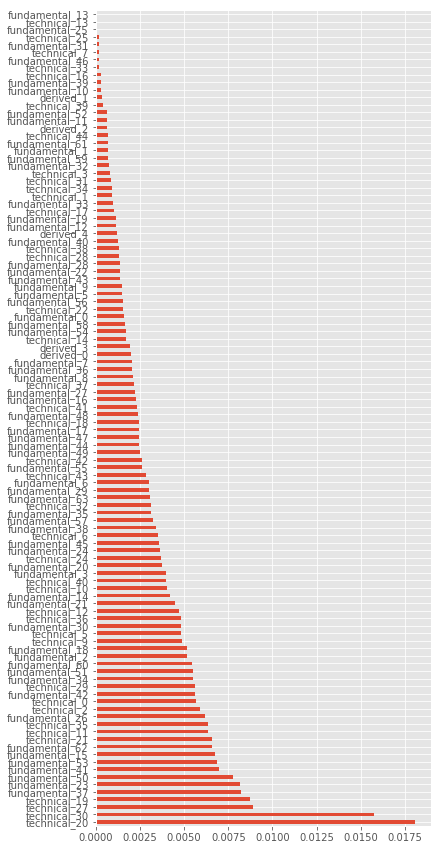

In [22]:
# Correlation?
corr = df[cols].corrwith(df['y'], drop=True)
abs_corr = abs(corr).sort_values(ascending=False)
abs_corr.plot.barh(figsize=(6,15))

# Highest correlation
high_corr = abs_corr.index[0]

# All highest correlation
cols_corr = corr[abs(corr) > 0.005]
print(cols_corr)
cols_corr = cols_corr.index

total: 12%
Index(['fundamental_1', 'fundamental_5', 'fundamental_6', 'fundamental_9',
       'fundamental_22', 'fundamental_24', 'fundamental_26', 'fundamental_28',
       'fundamental_38', 'fundamental_49', 'fundamental_57', 'fundamental_61'],
      dtype='object')


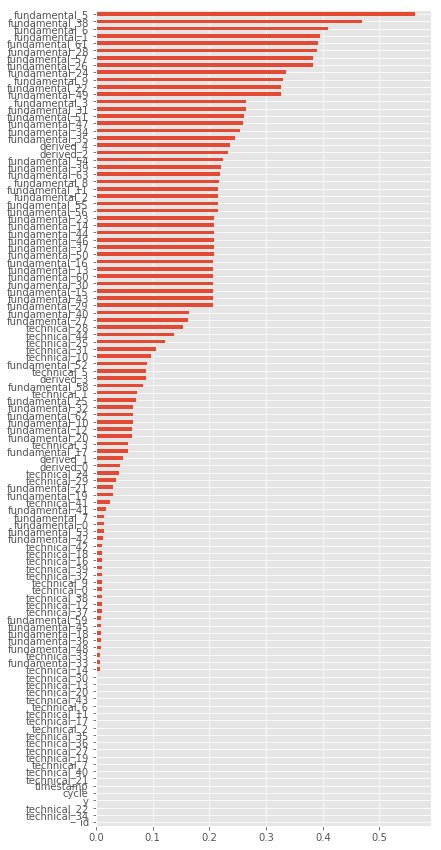

In [23]:
# Number of missing values
n = df.shape[0]
nas = df.isnull().sum()/n
nas.sort_values().plot.barh(figsize=(6,15))

print("total: {:.0%}".format(nas.mean()))

# Columns with too many missing values?
cols_na = df.columns[nas > 0.3]

print(cols_na)

# Drop columns with too many missing values
# df.drop(cols_na, axis=1, inplace=True)

In [24]:
# Number of nulls in row
df['rownull'] = df.isnull().sum(axis=1)

# Flag missing values
for c in cols:
    df[c + '_na'] = pd.isnull(df[c])

# Categories?
We can look at the distribution, as done by [wangruixin](https://www.kaggle.com/wangruixin/two-sigma-financial-modeling/randomforestregressor)

(171076, 221)


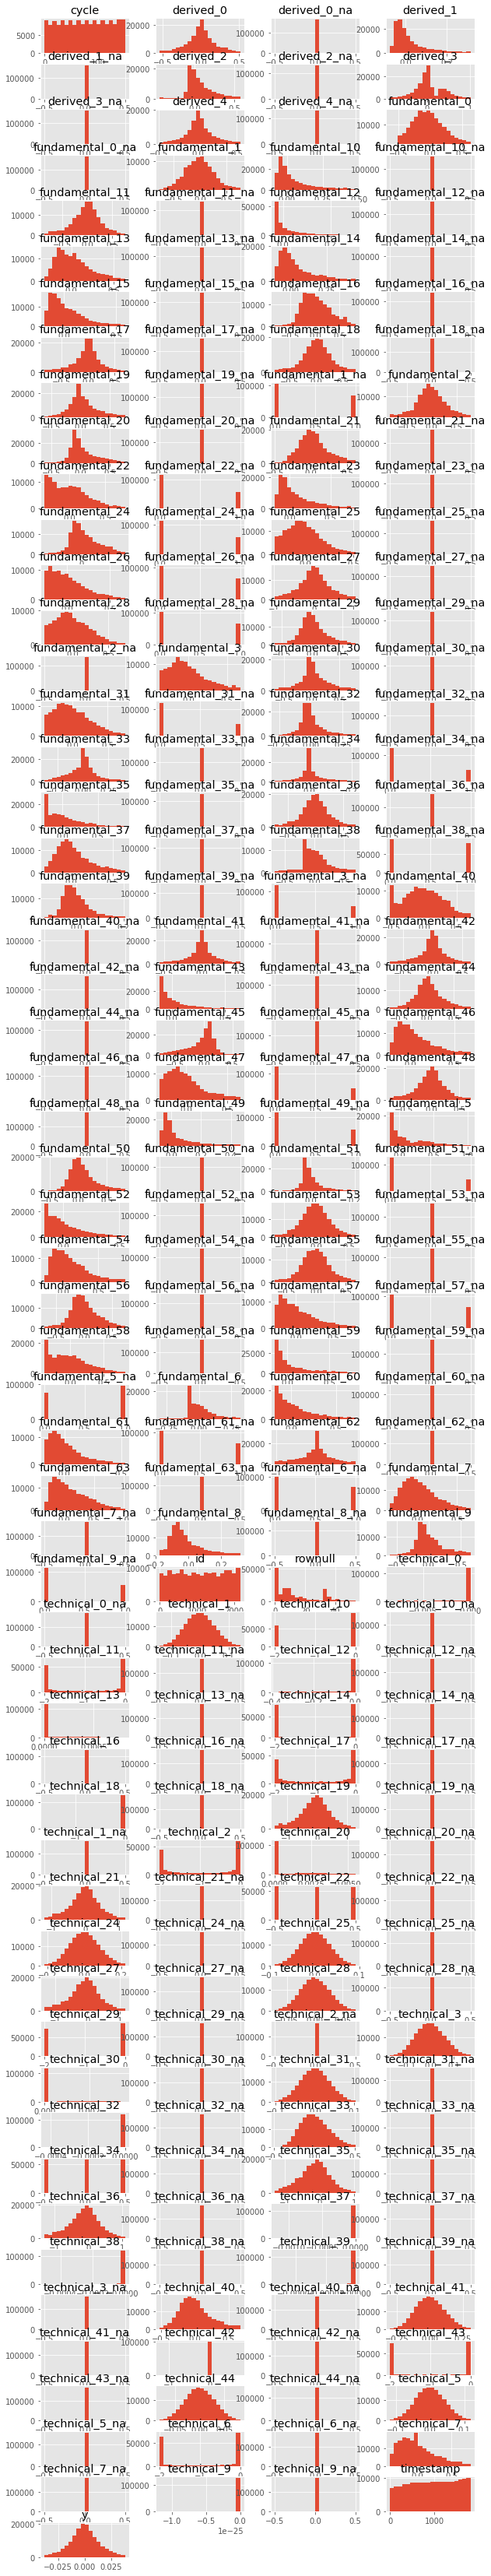

In [25]:
def remove_outliers(col):
    """Remove outliers from column."""
    
    # Ignore missing values
    col = col.dropna()
    
    # First quantile
    q_low = col.quantile(.25)
    q_high = col.quantile(.75)
    q_diff = q_high - q_low
    
    # Add buffer to quantile
    low = q_low - 1.5 * q_diff
    high = q_high + 1.5 * q_diff
    
    # Drop values outside range
    col[(col > high) | (col < low)] = np.nan
    
    return col

# Plot histogram after removing outliers
df.apply(remove_outliers).hist(
    layout=(-1, 4), figsize=(10, 60), bins=20, sharex=False, sharey=False
)

print(df.shape)

In [26]:
# Columns with thin histograms
cols_one = ['technical_13', 'technical_16', 'technical_18', 'technical_20', 'technical_30',
            'technical_42', 'technical_9', 'technical_0', 'technical_12', 'technical_37',
            'technical_38', 'technical_39']
cols_two = ['technical_10', 'technical_29', 'technical_14', 'technical_43', 'technical_6']
cols_three = ['technical_22', 'technical_34']
# Could also do some clustering instead

# Drop columns with one category
# df.drop(cols_one, inplace=True, axis=1)

# One-hot encode categories
df[cols_two] = df[cols_two].apply(lambda x: x > -1)

# One-hot encode categories
for c in cols_three:
    df[c + '_A'] = df[c] > 2.5
    df[c + '_B'] = df[c] < -1.5
df.drop(cols_three, inplace=True, axis=1)

print(df.shape)

(171076, 223)


# Outliers and missing values

-0.03800803341437131 0.03806452068965882
14133
-0.0860941 0.0934978
(171076, 223)


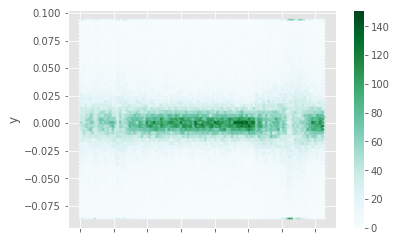

In [27]:
def compute_range(col):
    """Find range for most values."""
    
    # Ignore missing values
    col = col.dropna()

    # First quantile
    q_low = col.quantile(.25)
    q_high = col.quantile(.75)
    q_diff = q_high - q_low

    # Add buffer to quantile
    low = q_low - 1.5 * q_diff
    high = q_high + 1.5 * q_diff
    
    return low, high

y_low, y_high = compute_range(df['y'])

def find_outliers(col, index=True):
    """Find outliers in column."""

    low, high = compute_range(col)
    print(low, high)

    # Drop values outside range
    outliers = (col > high) | (col < low)

    if index:
        return df[outliers].index
    else:
        return outliers

# Find outliers in target
outliers = find_outliers(df['y'])
print(len(outliers))

# Remove outliers
# df.drop(outliers, inplace=True)

# Record min/max at this point, useful for clipping
y_max = max(df['y'])
y_min = min(df['y'])
print(y_min, y_max)

df.plot.hexbin('timestamp', 'y')
print(df.shape)

In [28]:
# Fill missing values

# df = df.sort_values(by='id')
# df = df.sort_values(by='timestamp')
# df = df.sort_values(by='y')  # Assume similarity between nearby targets

# df = df.fillna(method='ffill')
# df = df.fillna(method='bfill')

# Find medians ID combined and not
mean_values = df.median(axis=0)
mean_values_id = df.groupby('id').median()

# Fill medians per ID, and then remaining.
df.fillna(mean_values_id, inplace=True)
df.fillna(mean_values, inplace=True)

df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_39_na,technical_40_na,technical_41_na,technical_42_na,technical_43_na,technical_44_na,technical_22_A,technical_22_B,technical_34_A,technical_34_B
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,True,False,True,True,False,True,False,False,False,False
10,41,0,0.435826,1.797289,0.363570,-0.005651,0.442866,0.125375,0.113292,0.292311,...,True,False,True,True,False,True,False,False,False,False
20,69,0,-0.062361,-0.063724,0.021274,0.032845,0.174025,0.122335,-0.133188,-0.108286,...,True,False,True,True,False,True,False,False,False,False
30,91,0,-0.019409,-0.060192,-0.044959,0.100994,-0.056158,-0.161525,-0.175685,0.422399,...,True,False,True,True,False,True,False,False,False,False
40,118,0,-0.048108,0.036918,0.182193,0.387648,-0.064894,-0.060405,-0.291853,-0.380110,...,True,False,True,True,False,True,False,False,False,False


In [29]:
# Some rows are all missing values in test set
# https://www.kaggle.com/c/two-sigma-financial-modeling/discussion/26205
df.dropna(how='all', axis=1, inplace=True)

# Prediction

In [30]:
cols = [c for c in df.columns if c not in excl]
# cols = [c for c in df.columns if c not in excl and c in cols_corr]
# cols = ['fundamental_17', 'fundamental_41', 'technical_19', 'fundamental_62', 'fundamental_48']

target = df[col_target]
feature = df[cols]

print(feature.columns)

Index(['derived_0', 'derived_1', 'derived_2', 'derived_3', 'derived_4',
       'fundamental_0', 'fundamental_1', 'fundamental_2', 'fundamental_3',
       'fundamental_5',
       ...
       'technical_39_na', 'technical_40_na', 'technical_41_na',
       'technical_42_na', 'technical_43_na', 'technical_44_na',
       'technical_22_A', 'technical_22_B', 'technical_34_A', 'technical_34_B'],
      dtype='object', length=220)


In [31]:
def split_train_test(feature, target, cutoff_test = 1400):
    """
    Divide features and targets into train and test
    """

    ind_test = feature.index >= cutoff_test
    feature_test = feature[ind_test]
    target_test = target[ind_test]

    ind_train = ~ind_test
    feature_train = feature[ind_train]
    target_train = target[ind_train]
    
    return feature_train, feature_test, target_train, target_test

# Apply split
feature_train, feature_test, target_train, target_test = split_train_test(feature, target)

In [32]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, Lasso

# LassoCV since L1 norm promotes sparsity of features
clf = LassoCV()
# clf = LassoCV(alphas=[0.01, 0.1, 0.5, 1.])
# clf = Lasso(alpha=0.01)
# sfm = SelectFromModel(clf, threshold = 1e-7)
sfm = SelectFromModel(clf, threshold = "mean")
sfm.fit(feature_train, target_train)
# NOTE had to disable mkl as discussed here: https://github.com/BVLC/caffe/issues/3884

feature_kept = feature.columns[sfm.get_support()]
print("Features: {}".format(feature_kept))

/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Features: Index(['fundamental_17'], dtype='object')


In [33]:
# Keep only most important features
# feature_train = pd.DataFrame(sfm.transform(feature_train), 
#                              columns = feature_kept, index = feature_train.index)
# feature_test = pd.DataFrame(sfm.transform(feature_test), 
#                             columns = feature_kept, index = feature_test.index)

In [34]:
from sklearn.linear_model import LassoCV

# LassoCV since L1 norm promotes sparsity of features
reg = LassoCV(alphas=[0.001, 0.01, 0.1, 0.5, 1., 10, 100])
reg.fit(feature_train, target_train)

print(reg.alpha_)
print(reg.coef_)
print(reg.mse_path_)

0.1
[ 0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.00012222 -0.         -0.          0.         -0.          0.          0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.          0.        

/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [35]:
from sklearn.linear_model import RidgeCV

# LassoCV since L1 norm promotes sparsity of features
reg = LassoCV(alphas=[0.001, 0.01, 0.1, 0.5, 1., 10, 100, 10**3, 10**5])
reg.fit(feature_train, target_train)

print(reg.alpha_)
print(reg.coef_)
print(reg.mse_path_)

0.1
[ 0.         -0.          0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.00012222 -0.         -0.          0.         -0.          0.          0.
  0.         -0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.         -0.          0.
 -0.          0.          0.          0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.          0.        

/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [36]:
from sklearn.linear_model import ElasticNetCV

# LassoCV since L1 norm promotes sparsity of features
reg = ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 0.5, 1., 10, 100, 10**3, 10**5],
    l1_ratio = [0., 0.01, 0.1, 0.5, 0.8, 0.95, 0.99, 1.]
)
reg.fit(feature_train, target_train)

print(reg.alpha_)
print(reg.l1_ratio_)
print(reg.coef_)
print(reg.mse_path_)

/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:465: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10.0
0.0
[  5.62302207e-05  -8.51815822e-05   1.09152046e-04  -2.82908448e-05
   6.12556376e-05  -1.33578378e-05  -9.35290372e-05  -1.80708712e-04
   1.14556829e-05  -2.77315268e-05   2.73001073e-05   6.63840405e-05
  -5.70313434e-06   1.26830640e-04  -4.91278708e-05   1.34487140e-05
  -5.20155472e-05   2.19658666e-06   5.75684996e-05   6.34516492e-05
  -9.16549378e-06   3.08229038e-04  -2.28478545e-04   7.97896961e-05
   1.28194272e-04  -8.85185445e-05   1.85011398e-04   1.91275926e-04
   6.51303207e-05  -2.55471595e-05   1.31957274e-05  -1.20155726e-04
  -3.63839339e-05   3.04171415e-05  -2.07922977e-04  -9.15859406e-07
  -5.88461093e-05   7.79040579e-05   7.54308414e-05  -5.88365925e-05
  -2.24048521e-04   4.73463360e-05  -1.07153129e-05   8.47368415e-05
   3.96611733e-06   3.52013478e-04   2.41830445e-04  -3.59173935e-05
  -1.68100672e-04  -1.19604578e-04   5.73260298e-05  -1.35650497e-05
  -9.99286372e-05  -1.46108583e-04   1.17908127e-05   8.71224920e-05
  -3.48964571e-05  -1.857

/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:465: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/usr/lib/python3/dist-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [37]:
reg = ElasticNetCV(alphas=[0.001, 0.01, 0.1, 0.5, 1.], l1_ratio=[0.1])

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

reg = RandomForestRegressor()
tuned_params = {'n_estimators': [100, 500, 1000], 'max_depth': [None, 1, 2, 5, 10], 'min_samples_split': [1, 2, 3]}

# reg = ExtraTreesRegressor()
# tuned_params = {'n_estimators': [100, 500, 1000], 'max_depth': [None, 1, 2, 5, 10], 'min_samples_split': [1, 2, 3]}

# reg = ExtraTreesRegressor()
# reg = ExtraTreesRegressor(n_estimators=100, max_depth=4)

gs = GridSearchCV(reg, tuned_params, cv=5, n_jobs=-1, verbose=1)
gs.fit(feature_train, target_train)

from pprint import pprint
pprint(gs.grid_scores_)
reg = gs.best_estimator_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  1.3min finished


[mean: -0.35182, std: 0.20757, params: {'max_depth': None, 'n_estimators': 100, 'min_samples_split': 1},
 mean: -0.30069, std: 0.18023, params: {'max_depth': None, 'n_estimators': 500, 'min_samples_split': 1},
 mean: -0.30322, std: 0.17692, params: {'max_depth': None, 'n_estimators': 1000, 'min_samples_split': 1},
 mean: -0.32386, std: 0.19529, params: {'max_depth': None, 'n_estimators': 100, 'min_samples_split': 2},
 mean: -0.30676, std: 0.16799, params: {'max_depth': None, 'n_estimators': 500, 'min_samples_split': 2},
 mean: -0.30088, std: 0.14382, params: {'max_depth': None, 'n_estimators': 1000, 'min_samples_split': 2},
 mean: -0.31754, std: 0.19107, params: {'max_depth': None, 'n_estimators': 100, 'min_samples_split': 3},
 mean: -0.28222, std: 0.14189, params: {'max_depth': None, 'n_estimators': 500, 'min_samples_split': 3},
 mean: -0.29665, std: 0.17101, params: {'max_depth': None, 'n_estimators': 1000, 'min_samples_split': 3},
 mean: -0.08132, std: 0.10854, params: {'max_depth':

/usr/lib/python3/dist-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [42]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# reg = LinearRegression()
# reg = ElasticNet(alpha=0.01, l1_ratio=0.1)
reg = ExtraTreesRegressor(n_estimators=100, max_depth=4)

# Quick cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg, feature, target, cv=5)
print("R^2 during CV: {:.3f} +/- {:.3f}".format(scores.mean(), scores.std()))
print(scores)

reg.fit(feature_train, target_train)

R^2 during CV: -0.000 +/- 0.001
[  5.32973836e-04  -1.03309117e-04   8.28338298e-05  -5.70444896e-04
  -9.39344189e-04]


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=4,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [43]:
# Score on train/test set
from sklearn.metrics import r2_score

pred_train = reg.predict(feature_train)
# pred_train = clip(pred_train)
# pred_train = pred_train.clip(y_min, y_max)
print('train score: {}'.format(r2_score(target_train, pred_train)))

pred_test = reg.predict(feature_test)
# pred_test = clip(pred_test)
# pred_test = pred_test.clip(y_min, y_max)
print('test score: {}'.format(r2_score(target_test, pred_test)))

# Big difference! Overfitting?

train score: 0.4026245587403747
test score: -0.11705780124065424


In [46]:
# print(reg.coef_)

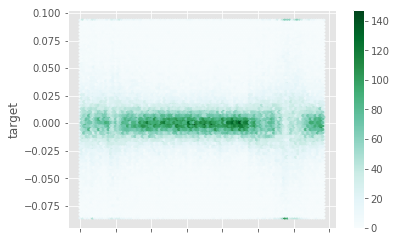

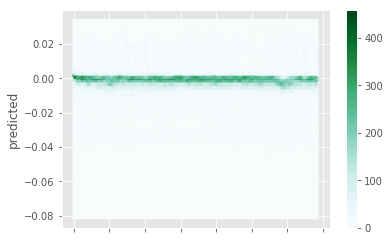

In [47]:
r = pd.DataFrame({'target': target_test.values, 'predicted': pred_test, 'timestamp': target_test.index})

r.plot.hexbin('timestamp', 'target')
r.plot.hexbin('timestamp', 'predicted')

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# r.plot.hexbin('timestamp', 'target', ax=axes[0], sharex=False, sharey=True, legend=False)
# r.plot.hexbin('timestamp', 'predicted', ax=axes[1], sharex=False, sharey=True, legend=False)

# plt.subplots_adjust(wspace=0.5, hspace=0.5);

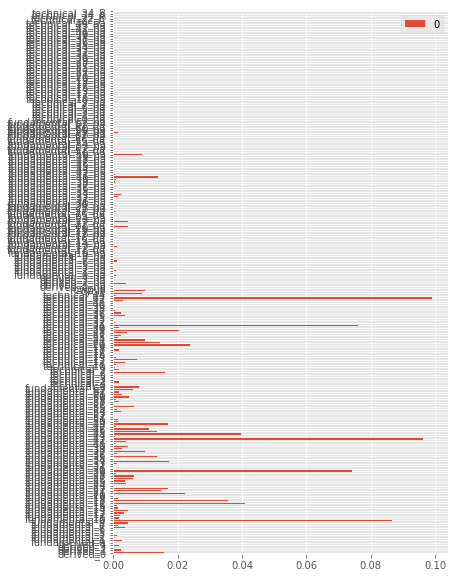

In [48]:
try:
    pd.DataFrame(reg.feature_importances_, index=feature_train.columns).plot.barh(figsize=(6,10))
except AttributeError:
    pass
cols_important = ['fundamental_17', 'fundamental_41', 'technical_19', 'fundamental_62', 'fundamental_48']

In [49]:
def mape(outcome, predict):
    """
    Compute Mean Absolute Percentage Error (MAPE) score. Positive, but lower is better.
    """
    
    outcome = np.array(outcome).ravel()
    predict = np.array(predict).ravel()
    
    # Get only the NONZERO or NON-NAN elements
    EPSILON = pow(10, -5)
    idx = (np.abs(outcome) > EPSILON) | (~np.isnan(outcome)) | (~np.isnan(predict))
    
    # Extract those elements
    outcome = outcome[np.where(idx)]
    predict = predict[np.where(idx)]
    
    return np.mean(np.abs((outcome - predict) / outcome))

scores = {}

scores['MAPE'] = mape(target_test, pred_test)
        
from sklearn.metrics import r2_score
scores['R2'] = r2_score(target_test, pred_test)

from sklearn.metrics import explained_variance_score
scores['Explained Variance'] = explained_variance_score(target_test, pred_test)

from sklearn.metrics import mean_squared_error
scores['Mean Square Error'] = mean_squared_error(target_test, pred_test)
scores['Root Mean Square Error'] = np.sqrt(scores['Mean Square Error'])
    
from sklearn.metrics import median_absolute_error
scores['Median Absolute Error'] = median_absolute_error(target_test, pred_test)

print(pd.Series(scores))

Explained Variance       -0.105706
MAPE                           inf
Mean Square Error         0.000562
Median Absolute Error     0.010330
R2                       -0.117058
Root Mean Square Error    0.023716
dtype: float64


/usr/lib/python3/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide


# Combining models

We can combine a tree with linear regression, as done by [dikshant2210](https://www.kaggle.com/dikshant2210/two-sigma-financial-modeling/winter/run/652355).

In [50]:
cols = [c for c in df.columns if c not in excl]

target = df[col_target]
feature = df[cols]

feature_train, feature_test, target_train, target_test = split_train_test(feature, target)

In [51]:
# Find medians per columns
# mean_values = feature_train.median(axis=0)
mean_values = df.median(axis=0)

# Fill using medians
feature_train.fillna(mean_values, inplace=True)
feature_test.fillna(mean_values, inplace=True)

mean_values

/usr/lib/python3/dist-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


id                 1098.000000
timestamp           956.000000
derived_0            -0.001554
derived_1             0.005532
derived_2             0.021194
derived_3             0.003114
derived_4             0.013201
fundamental_0        -0.040254
fundamental_1        -0.006849
fundamental_2        -0.031945
fundamental_3        -0.040412
fundamental_5         0.031904
fundamental_6        -0.010860
fundamental_7         0.015456
fundamental_8        -0.029173
fundamental_9        -0.022926
fundamental_10        0.014540
fundamental_11       -0.024110
fundamental_12        0.000311
fundamental_13        0.009030
fundamental_14        0.016279
fundamental_15        0.008340
fundamental_16       -0.021261
fundamental_17       -0.016687
fundamental_18       -0.005612
fundamental_19        0.020412
fundamental_20       -0.008012
fundamental_21        0.032727
fundamental_22       -0.017778
fundamental_23        0.033809
                      ...     
technical_17_na       0.000000
technica

In [52]:
# Model for tree

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
reg1 = ExtraTreesRegressor(n_estimators=100, max_depth=4)

reg1.fit(feature_train, target_train)

# Score on train/test set
from sklearn.metrics import r2_score

pred_train1 = reg1.predict(feature_train)
pred_train1 = pd.Series(pred_train1, index=feature_train.index)
pred_train1 = pred_train1.clip(y_low, y_high)
print('train score: {}'.format(r2_score(target_train, pred_train1)))

pred_test1 = reg1.predict(feature_test)
pred_test1 = pd.Series(pred_test1, index=feature_test.index)
pred_test1 = pred_test1.clip(y_low, y_high)
print('test score: {}'.format(r2_score(target_test, pred_test1)))

train score: 0.3633828503673485
test score: -0.10417176844156062


In [53]:
# Model for linear regression

from sklearn.linear_model import LinearRegression, ElasticNet
reg2 = LinearRegression()
# reg2 = ElasticNet(alpha=0.01, l1_ratio=0.1)

# Ignore outliers and use only column with highest correlation
outliers = find_outliers(target_train, index=False)
feature_train2 = feature_train.loc[~outliers, [high_corr]]
target_train2 = target_train.loc[~outliers]

reg2.fit(feature_train2, target_train2)

# Score on train/test set
from sklearn.metrics import r2_score

pred_train2 = reg2.predict(feature_train.loc[:, [high_corr]])
pred_train2 = pd.Series(pred_train2, index=feature_train.index)
pred_train2 = pred_train2.clip(y_low, y_high)
print('train score: {}'.format(r2_score(target_train, pred_train2)))

pred_test2 = reg2.predict(feature_test.loc[:, [high_corr]])
pred_test2 = pd.Series(pred_test2, index=feature_test.index)
pred_test2 = pred_test2.clip(y_low, y_high)
print('test score: {}'.format(r2_score(target_test, pred_test2)))

-0.05741414928343147 0.057555349194444716
train score: -0.0012794190437368513
test score: -0.009290719726936292


In [54]:
# Score on train/test set

pred_train = .65 * pred_train1 + .35 * pred_train2
print('train score: {}'.format(r2_score(target_train, pred_train)))

pred_test = .65 * pred_test1 + .35 * pred_test2
print('test score: {}'.format(r2_score(target_test, pred_test)))

train score: 0.25937512519324035
test score: -0.044732699539998144


In [55]:
print("Notebook ran in {:.1f} minutes".format((clock() - start_notebook)/60))

Notebook ran in 9.6 minutes
